# Mode prediction -- multiple steps -- different features

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [104]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

## Processing functions

In [105]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [123]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3)
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    f = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(np.array(pred), color=colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.show()

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    _, ax = plt.subplots(figsize=(10, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='bottom-left')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    add_value_labels(bars2)

    plt.show()

In [107]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op1_merged.csv'
operator = 'Operator 1'

In [108]:
op1_overlap = ['Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi_Test_2_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Viale_Marconi_No_Flight_Mode', 
               'Capacity_Ookla_UNIDATA_4G5G_TIM_Driving_Viale_Marconi',
               'Interactivity_gaming_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode',
               'Ping_UNIDATA_4G5G_TIM_Driving_Palasport_to_Via_Appia_End_No_Flight_Mode']
test = read_dataset(dataset, campaigns=[op1_overlap[0]])
train = read_dataset(dataset, campaigns=op1_overlap[1:4])

route_to_add = read_dataset(dataset, campaigns=[op1_overlap[4]])
train = pd.concat([route_to_add[5400::], train])
train.reset_index(drop=True, inplace=True)

route_to_add = read_dataset(dataset, campaigns=[op1_overlap[5]])
train = pd.concat([route_to_add[0:1180], train])
train.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [109]:
target_features = ['Mode']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

## 1 step ahead

In [110]:
# parameters
n_steps_in = 2
n_steps_out = 1
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.550,0.513,0.043,0.768,0.463,0.136
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.577,0.749,0.094,0.743,0.311,0.106
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.592,0.634,0.226,0.763,0.403,0.091
6,"RSRP, SINR, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
7,SSS_RSRP,0.549,0.000,0.000,0.773,0.000,0.000
8,SSS_SINR,0.564,0.591,0.109,0.749,0.430,0.328
9,SSS_RSRQ,0.630,0.649,0.392,0.732,0.447,0.765


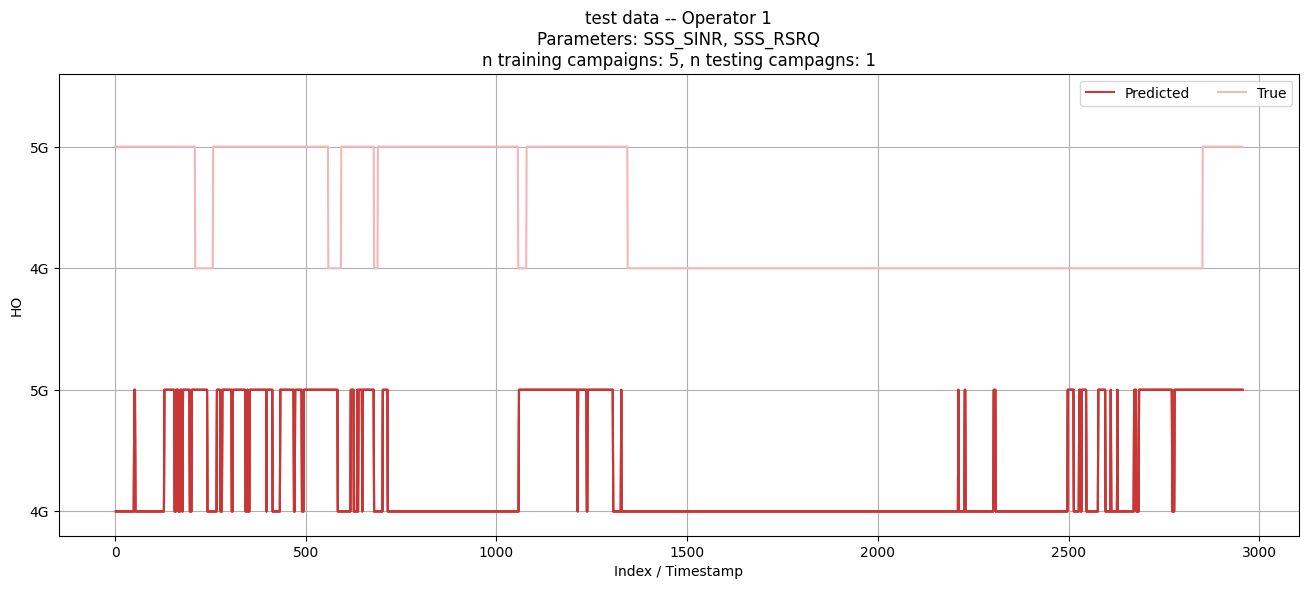

In [111]:

combination = 'SSS_SINR, SSS_RSRQ'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)

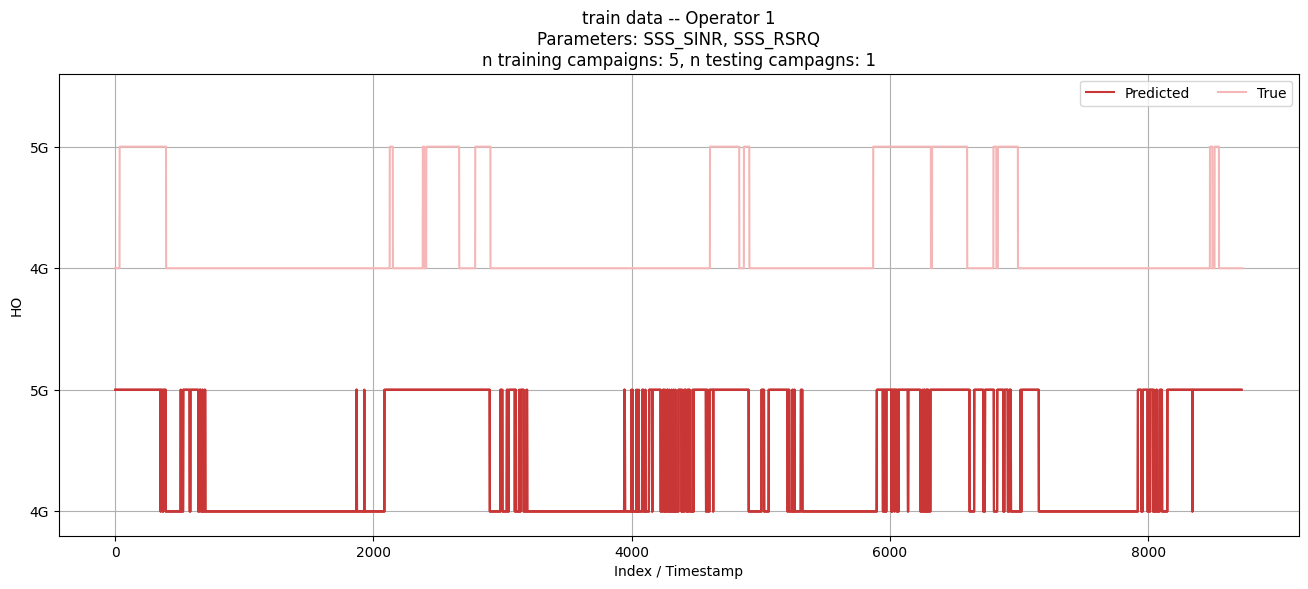

In [112]:
plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)

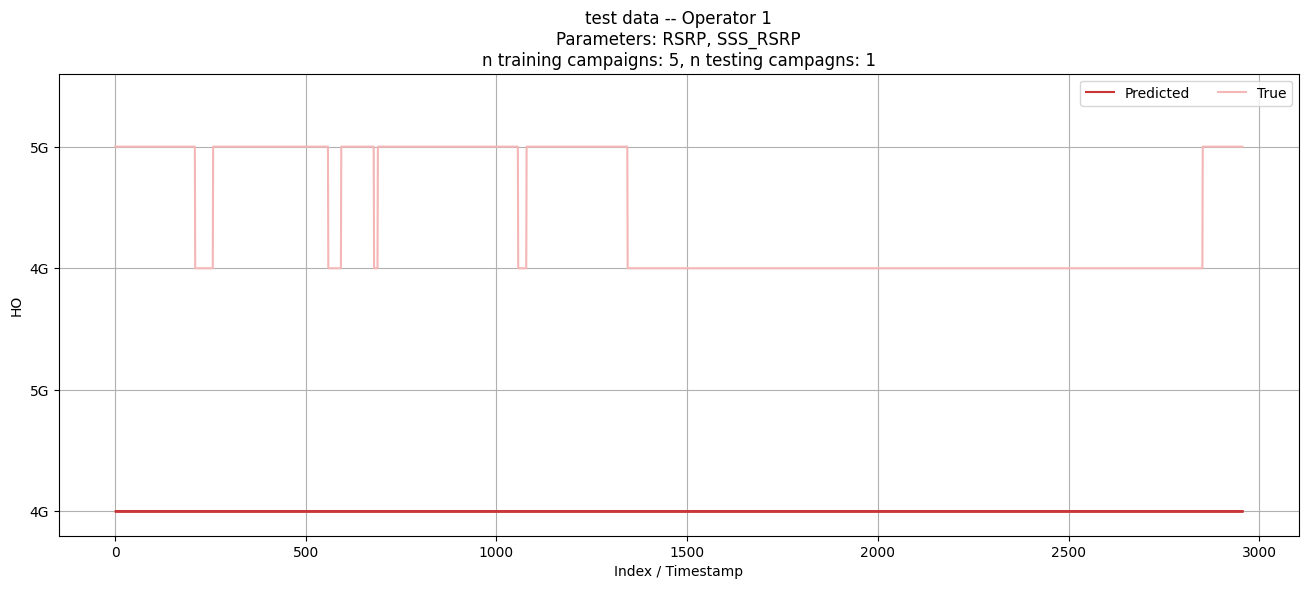

In [ ]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

plot_mode(pred=pred, true=true, colors=mode_colors, operator=operator, test_train='test', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)


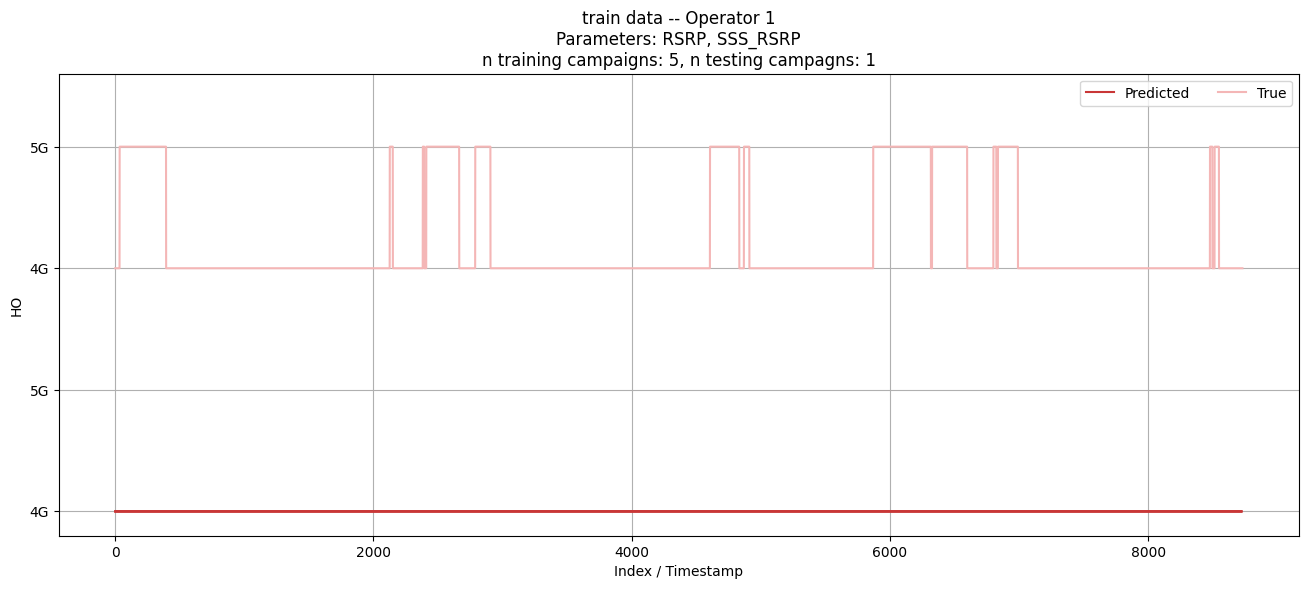

In [114]:
plot_mode(pred=train_pred, true=train_true, colors=mode_colors, operator=operator, test_train='train', comb=combination, campaigns=campaigns, test_campaigns=test_campaigns)

## 2 steps ahead

In [115]:
# parameters
n_steps_in = 2
n_steps_out = 2
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.550,0.511,0.044,0.767,0.435,0.087
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.559,0.510,0.591,0.693,0.386,0.593
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.549,0.500,0.051,0.773,0.501,0.112
6,"RSRP, SINR, RSRQ",0.551,0.667,0.011,0.759,0.352,0.072
7,SSS_RSRP,0.552,0.573,0.032,0.747,0.308,0.093
8,SSS_SINR,0.562,0.544,0.183,0.737,0.437,0.558
9,SSS_RSRQ,0.549,0.000,0.000,0.773,0.000,0.000


Number of predicted 5G point: 2352


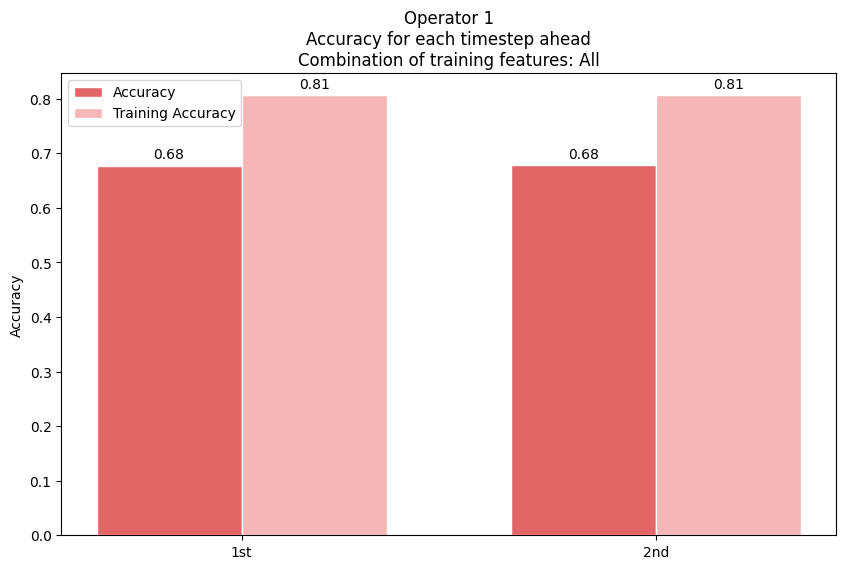

In [116]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

In [117]:
# parameters
n_steps_in = 3
n_steps_out = 3
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.549,0.000,0.000,0.773,0.000,0.000
1,SINR,0.543,0.388,0.023,0.789,0.617,0.182
2,RSRQ,0.549,0.000,0.000,0.773,0.000,0.000
3,"RSRP, SINR",0.529,0.483,0.627,0.687,0.387,0.652
4,"RSRP, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
5,"SINR, RSRQ",0.547,0.481,0.052,0.745,0.358,0.155
6,"RSRP, SINR, RSRQ",0.549,0.000,0.000,0.773,0.000,0.000
7,SSS_RSRP,0.549,0.000,0.000,0.773,0.000,0.000
8,SSS_SINR,0.576,0.613,0.162,0.748,0.445,0.452
9,SSS_RSRQ,0.549,0.000,0.000,0.773,0.000,0.000


Number of predicted 5G point: 1653


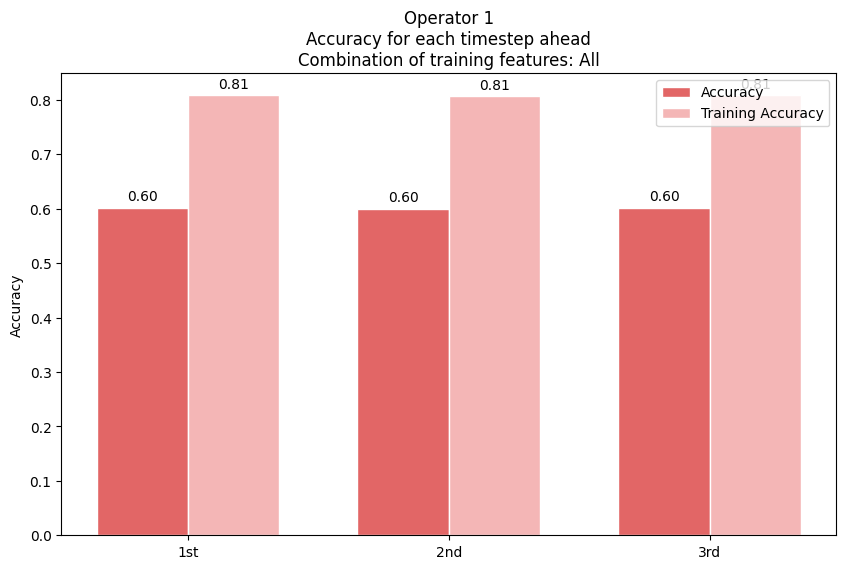

In [118]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

In [119]:
# parameters
n_steps_in = 5
n_steps_out = 5
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.550,0.000,0.000,0.774,0.000,0.000
1,SINR,0.550,0.000,0.000,0.774,0.000,0.000
2,RSRQ,0.550,0.000,0.000,0.774,0.000,0.000
3,"RSRP, SINR",0.565,0.571,0.133,0.750,0.406,0.229
4,"RSRP, RSRQ",0.550,0.000,0.000,0.774,0.000,0.000
5,"SINR, RSRQ",0.639,0.661,0.407,0.729,0.356,0.244
6,"RSRP, SINR, RSRQ",0.550,0.000,0.000,0.774,0.000,0.000
7,SSS_RSRP,0.550,0.000,0.000,0.774,0.000,0.000
8,SSS_SINR,0.580,0.616,0.177,0.754,0.459,0.501
9,SSS_RSRQ,0.596,0.672,0.199,0.774,0.500,0.621


Number of predicted 5G point: 5641


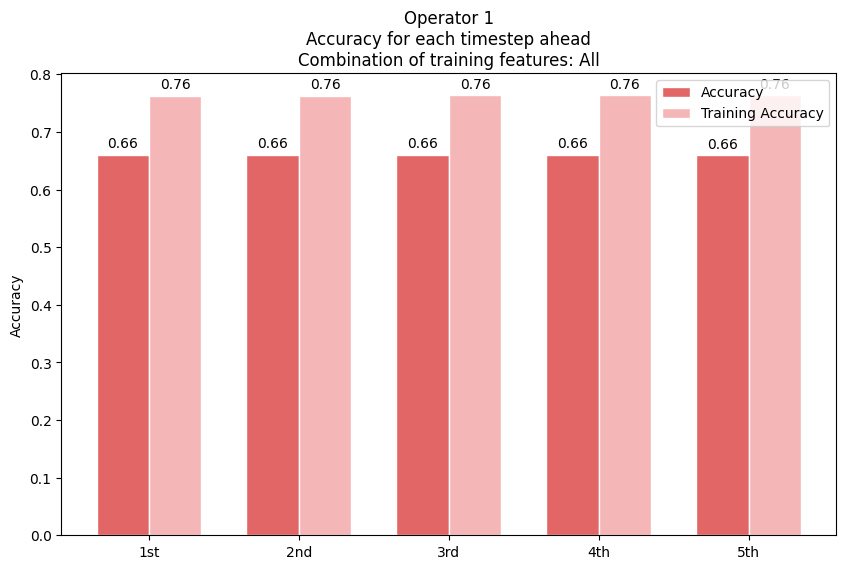

In [120]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)

In [121]:
# parameters
n_steps_in = 8
n_steps_out = 10
n_first_units = 5
n_second_units = 10

results = {}

for target in target_features:
    for features in feature_selection:
        used_features = ''
        if len(features) == 6:
            used_features = 'All'
        else:
            used_features = ', '.join(features)
        features.append('campaign')
        features.append('Mode')
        warnings.simplefilter(action='ignore')
        results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

df_results = pd.DataFrame.from_dict(results, orient='index')
df_results.reset_index(inplace=True)
df_results.rename(columns={'index': 'Combination'}, inplace=True)
df_results = df_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot'], axis=1)
df_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.551,0.000,0.000,0.775,0.000,0.000
1,SINR,0.551,0.499,0.052,0.764,0.429,0.144
2,RSRQ,0.551,0.000,0.000,0.775,0.000,0.000
3,"RSRP, SINR",0.546,0.475,0.105,0.631,0.152,0.140
4,"RSRP, RSRQ",0.551,0.000,0.000,0.775,0.000,0.000
5,"SINR, RSRQ",0.628,0.644,0.384,0.759,0.455,0.350
6,"RSRP, SINR, RSRQ",0.551,0.000,0.000,0.775,0.000,0.000
7,SSS_RSRP,0.563,0.556,0.132,0.710,0.335,0.291
8,SSS_SINR,0.584,0.640,0.166,0.758,0.464,0.478
9,SSS_RSRQ,0.551,0.000,0.000,0.775,0.000,0.000


Number of predicted 5G point: 0


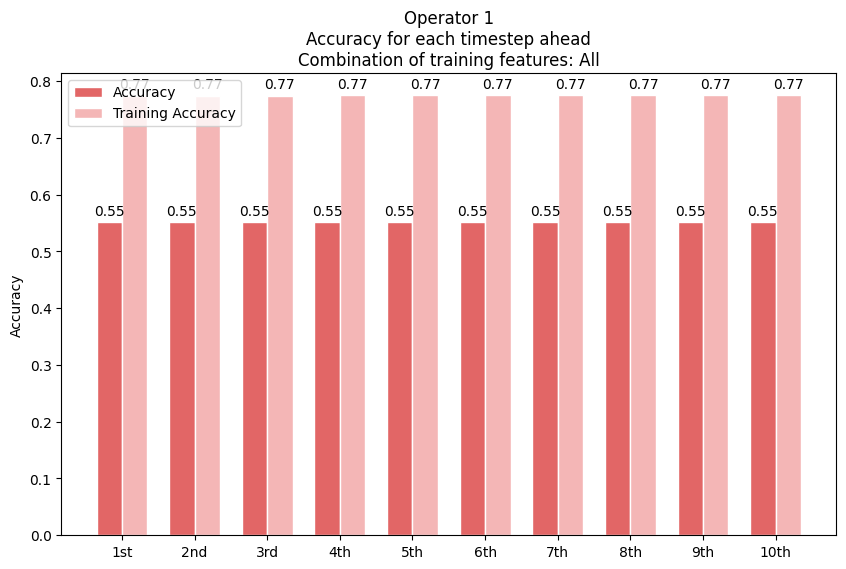

In [122]:
combination = 'All'
comb = results[combination]
pred = comb['y_pred']
true = comb['y_true']
train_pred = comb['train_pred']
train_true = comb['train_true']

print(f'Number of predicted 5G point: {np.sum(pred)}')

plot_accuracy_timesteps(true=true, pred=pred, train_true=train_true, train_pred=train_pred, comb=combination, n_steps_out=n_steps_out, operator=operator)